# Lesson 9: Segmentation

- In the classroom, the libraries are already installed for you.
- If you would like to run this code on your own machine, you can install the following:

```
    !pip install transformers
    !pip install gradio
    !pip install timm
    !pip install torchvision
```

- Here is some code that suppresses warning messages.

In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

### Mask Generation with SAM

The [Segment Anything Model (SAM)](https://segment-anything.com) model was released by Meta AI.

In [2]:
from transformers import pipeline

In [3]:
sam_pipe = pipeline("mask-generation",
    "./models/Zigeng/SlimSAM-uniform-77")

Info about [Zigeng/SlimSAM-uniform-77](https://huggingface.co/Zigeng/SlimSAM-uniform-77)

In [4]:
from PIL import Image

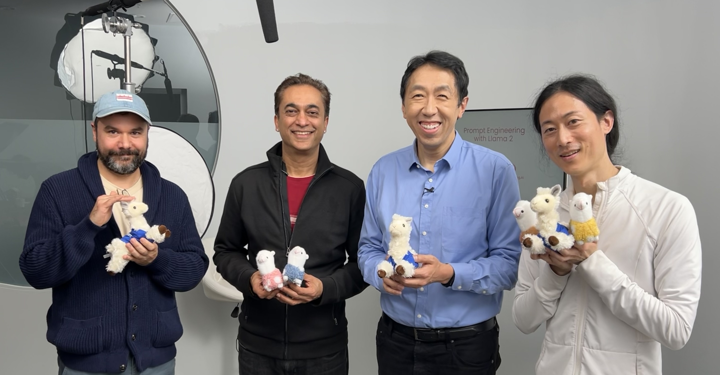

In [5]:
raw_image = Image.open('meta_llamas.jpg')
raw_image.resize((720, 375))

- Running this will take some time
- The higher the value of 'points_per_batch', the more efficient pipeline inference will be

In [6]:
output = sam_pipe(raw_image, points_per_batch=32)

In [7]:
from helper import show_pipe_masks_on_image

In [ ]:
show_pipe_masks_on_image(raw_image, output)

_Note:_ The colors of segmentation, that you will get when running this code, might be different than the ones you see in the video.

### Faster Inference: Infer an Image and a Single Point

In [ ]:
from transformers import SamModel, SamProcessor

In [ ]:
model = SamModel.from_pretrained(
    "./models/Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained(
    "./models/Zigeng/SlimSAM-uniform-77")

In [ ]:
raw_image.resize((720, 375))

- Segment the blue shirt Andrew is wearing.
- Give any single 2D point that would be in that region (blue shirt).

In [ ]:
input_points = [[[1600, 700]]]

- Create the input using the image and the single point.
- `return_tensors="pt"` means to return PyTorch Tensors.

In [ ]:
inputs = processor(raw_image,
                 input_points=input_points,
                 return_tensors="pt")

- Given the inputs, get the output from the model.

In [ ]:
import torch

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)

 Length of `predicted_masks` corresponds to the number of images that are used in the input.

In [ ]:
len(predicted_masks)

- Inspect the size of the first ([0]) predicted mask

In [ ]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

In [ ]:
outputs.iou_scores

In [ ]:
from helper import show_mask_on_image

In [ ]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

## Depth Estimation with DPT

- This model was introduced in the paper [Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413) by Ranftl et al. (2021) and first released in [isl-org/DPT](https://github.com/isl-org/DPT).

In [ ]:
depth_estimator = pipeline(task="depth-estimation",
                        model="./models/Intel/dpt-hybrid-midas")

Info about ['Intel/dpt-hybrid-midas'](https://huggingface.co/Intel/dpt-hybrid-midas)

In [ ]:
raw_image = Image.open('gradio_tamagochi_vienna.png')
raw_image.resize((806, 621))

- If you'd like to generate this image or something like it, check out the short course on [Gradio](https://www.deeplearning.ai/short-courses/building-generative-ai-applications-with-gradio/) and go to the lesson "Image Generation App".

In [ ]:
output = depth_estimator(raw_image)

In [ ]:
output

- Post-process the output image to resize it to the size of the original image.

In [ ]:
output["predicted_depth"].shape

In [ ]:
output["predicted_depth"].unsqueeze(1).shape

In [ ]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [ ]:
prediction.shape

In [ ]:
raw_image.size[::-1],

In [ ]:
prediction

- Normalize the predicted tensors (between 0 and 255) so that they can be displayed.

In [ ]:
import numpy as np 

In [ ]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

In [ ]:
depth

### Demo using Gradio

### Troubleshooting Tip
- Note, in the classroom, you may see the code for creating the Gradio app run indefinitely.
  - This is specific to this classroom environment when it's serving many learners at once, and you won't wouldn't experience this issue if you run this code on your own machine.
- To fix this, please restart the kernel (Menu Kernel->Restart Kernel) and re-run the code in the lab from the beginning of the lesson.

In [ ]:
import os
import gradio as gr
from transformers import pipeline

In [ ]:
def launch(input_image):
    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

In [ ]:
iface = gr.Interface(launch, 
                     inputs=gr.Image(type='pil'), 
                     outputs=gr.Image(type='pil'))

In [ ]:
iface.launch(share=True, server_port=int(os.environ['PORT1']))

In [ ]:
iface.close()

### Close the app
- Remember to call `.close()` on the Gradio app when you're done using it.

### Try it yourself! 
- Try this model with your own images!